# start

## load the dependencies


In [391]:


#Libraries we will need.
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## loading the data

In [393]:
# load the data its in the Train directory its not a csv its just wav files

# get every file from the Train directory
train_dir = '/Users/kaispeidel/Downloads/DeepLearning/Train'
train_files = os.listdir(train_dir)

# make csv file out of the files 
train_df = pd.DataFrame(train_files, columns=['file'])

# create a column with the file path 
train_df['file_path'] = train_df['file'].apply(lambda x: os.path.join(train_dir, x))

# create a column with the file name without the .wav extension
train_df['file_name'] = train_df['file'].str.replace('.wav', '')

# create a column with the accent from the first numer of the file name
train_df['accent'] = train_df['file_name'].str[0]

# create a column with male or female from the second incex of the file name
train_df['gender'] = train_df['file_name'].str[1]

train_df

,file,file_path,file_name,accent,gender
0,2m_9039.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2m_9039,2,m
1,4f_1887.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_1887,4,f
2,4f_9571.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_9571,4,f
3,1m_3736.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3736,1,m
4,1m_3078.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3078,1,m
...,...,...,...,...,...
3161,3f_3974.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,3f_3974,3,f
3162,3m_7330.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,3m_7330,3,m
3163,5f_2072.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,5f_2072,5,f
3164,2m_6475.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2m_6475,2,m


In [394]:
test_dir = '/Users/kaispeidel/Downloads/DeepLearning/Test'
test_files = os.listdir(test_dir)

test_df = pd.DataFrame(test_files, columns=['file'])
test_df['file_path'] = test_df['file'].apply(lambda x: os.path.join(test_dir, x))
test_df['file_name'] = test_df['file'].str.replace('.wav', '')

# create an empty column for the accent and gender
test_df['accent'] = ''
test_df['gender'] = ''
 
test_df

,file,file_path,file_name,accent,gender
0,9430.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,9430,,
1,4458.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4458,,
2,1534.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,1534,,
3,8510.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8510,,
4,7192.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,7192,,
...,...,...,...,...,...
546,8910.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8910,,
547,8904.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8904,,
548,4680.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4680,,
549,4858.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4858,,


## first try

from: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5/


## approach a) 

Use the raw input signal and analyze it as a 1D input; in this case, you can, of
course, apply simple pre-processing like standardization.

In [395]:
import librosa
import torch

def load_and_PreProcess(path):
    try: 
        audio, sr = librosa.load(path)
        audio_tensor = torch.tensor(audio)
        return audio_tensor, sr, audio
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None, None

In [421]:
# apply the function to all files in the train  dataframes first crete a new copy

nummer = len(train_df)

df= train_df[:nummer].copy()


In [422]:
lengths = []

for file in df['file_path']:
    audio, sr = librosa.load(file)
    lengths.append(len(audio))

max_length = max(lengths)
print(f"Max length: {max_length}")

Max length: 286003


## try agin

In [423]:
classes = df['accent'].unique()
print(f"Classes: {classes}")

Classes: ['2' '4' '1' '3' '5']


In [424]:
class_dict = {i:x for x,i in enumerate(classes)}
print(f"Class dict: {class_dict}")

Class dict: {'2': 0, '4': 1, '1': 2, '3': 3, '5': 4}


In [425]:
df['target'] = df['accent'].map(class_dict)
print("df shape: ", df.shape)

df shape:  (3166, 6)


In [426]:
data_dir = '/Users/kaispeidel/Downloads/DeepLearning/Train'
n_mfcc = 14       # or 40 for finer resolution
max_length = 1000    # adjust based on typical audio length
sr = 16000

In [427]:
def custom_pad_mfcc(mfcc, fixed_length):
    n_mfcc, time_steps = mfcc.shape
    padded = np.zeros((n_mfcc, fixed_length))  # Zero-filled array

    # Copy only what fits
    length_to_copy = min(time_steps, fixed_length)
    padded[:, :length_to_copy] = mfcc[:, :length_to_copy]
    
    return padded

In [428]:
X = []
y = []

for data in tqdm(df.iterrows(),  desc='Progress'):
    
    file_path = os.path.join(data_dir, data[1][0])
    sig, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc) # change n_mfcc to if needed higher for more finegraded features
    padded = custom_pad_mfcc(mfcc, max_length)

    X.append(padded)
    y.append(data[1][3]) # 4 is the target column
    



Progress: 0it [00:00, ?it/s]/var/folders/pt/w218tf6j5kz72yf4j8vy4g0r0000gn/T/ipykernel_80881/648645202.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file_path = os.path.join(data_dir, data[1][0])
/var/folders/pt/w218tf6j5kz72yf4j8vy4g0r0000gn/T/ipykernel_80881/648645202.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[1][3]) # 4 is the target column
Progress: 3166it [00:15, 208.20it/s]


### lengths inspection

In [429]:
lengths = []
for i in X:
    lengths.append((i.shape[1]))

<Figure size 1000x500 with 0 Axes>

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 3166.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([ 999.5 ,  999.52,  999.54,  999.56,  999.58,  999.6 ,  999.62,
         999.64,  999.66,  999.68,  999.7 ,  999.72,  999.74,  999.76,
         999.78,  999.8 ,  999.82,  999.84,  999.86,  999.88,  999.9 ,
         999.92,  999.94,  999.96,  999.98, 1000.  , 1000.02, 1000.04,
        1000.06, 1000.08, 1000.1 , 1000.12, 1000.14, 1000.16, 1000.18,
        1000.2 , 1000.22, 1000.24, 1000.26, 1000.28, 1000.3 , 1000.32,
        1000.34, 1000.36, 1000.38, 1000.4 , 1000.42, 1000.44, 1000.46,
        1000.48, 1000.5 ]),
 <BarContainer object of 50 artists>)

Text(0.5, 0, 'Length of MFCC')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution of MFCC Lengths')

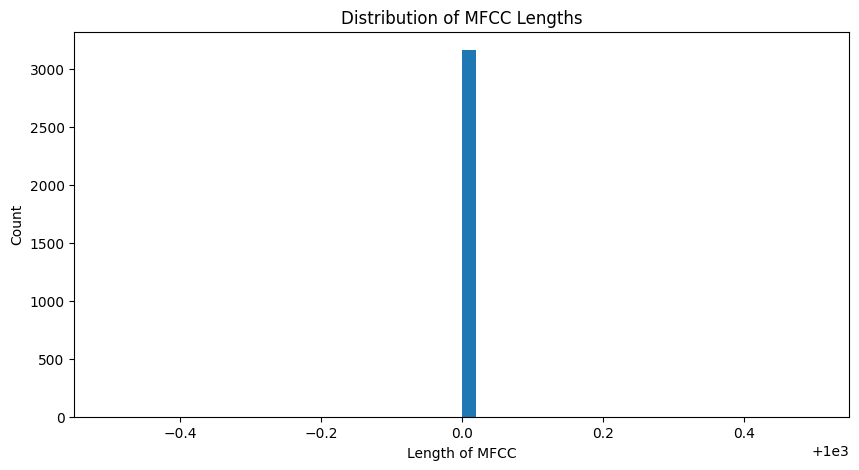

In [430]:
# plot distribution of lengths
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=50)
plt.xlabel('Length of MFCC')
plt.ylabel('Count')
plt.title('Distribution of MFCC Lengths')
plt.show()

### continue

In [431]:
X = np.array(X)
y = np.array(y)

In [432]:
y.shape

(3166,)

In [433]:
X.shape

(3166, 14, 1000)

In [434]:
y = np.array(y, dtype=int)

In [435]:
from tensorflow.keras.utils import to_categorical
y = y - 1
y = to_categorical(y, num_classes=5)
X = X.reshape((nummer, n_mfcc, max_length, 1)) 

In [436]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
X = X.reshape((nummer, n_mfcc, max_length, 1)) 

In [437]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (3166, 14, 1000, 1)
y Shape is:  (3166, 5)


In [438]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [439]:
INPUTSHAPE = (13, max_length, 1)

In [440]:
model =  models.Sequential([
    
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='same'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='same'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(512 , activation = 'relu'),
                          layers.Dense(5 , activation = 'softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 13, 1000, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 7, 500, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 7, 500, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 4, 250, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 4, 250, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 4, 250, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 2, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 2, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,509 (990.27 KB)

 Trainable params: 253,509 (990.27 KB)

 Non-trainable params: 0 (0.00 B)

In [441]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Adjust the number of epochs as needed
    batch_size=32,  # Adjust the batch size as needed
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.2340 - loss: 1.9856 - val_accuracy: 0.1798 - val_loss: 1.6185
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - accuracy: 0.3207 - loss: 1.5307 - val_accuracy: 0.4069 - val_loss: 1.3545
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.4739 - loss: 1.2751 - val_accuracy: 0.5347 - val_loss: 1.0959
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.5800 - loss: 1.0232 - val_accuracy: 0.5820 - val_loss: 0.9220
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.6313 - loss: 0.9201 - val_accuracy: 0.5599 - val_loss: 1.0083
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.6324 - loss: 0.9093 - val_accuracy: 0.6751 - val_loss: 0.7695
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.6952 - loss: 0.7719 - val_accuracy: 0.7035 - val_loss: 0.6845
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.6953 - loss: 0.7554 - val_accu

<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

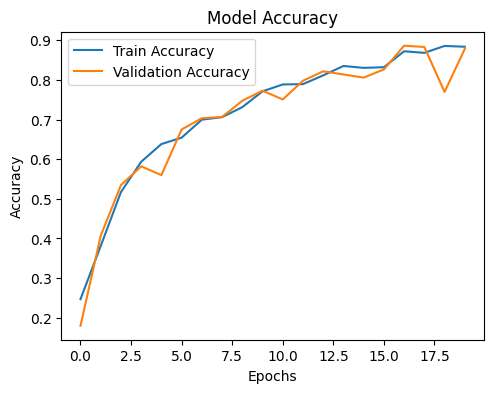

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

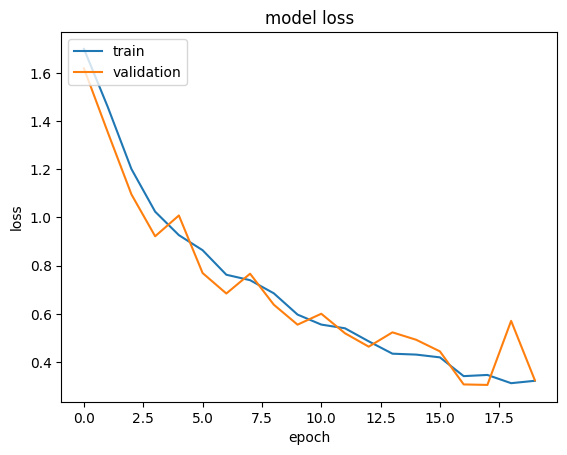

In [443]:
# plot the results

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [447]:
import keras

<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Axes: >

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

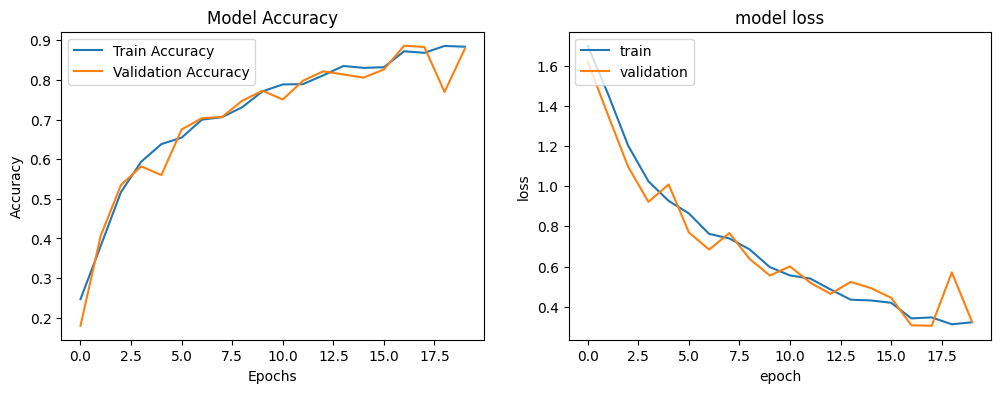

In [448]:
# save the plots as png in one plot

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model.png')
plt.show()

#save the model
keras.saving.save_model(model, 'my_model.keras')

